In [1]:
%cd ../..

c:\Users\olarinoyem\Project\Modern-Time-Series-Forecasting-with-Python-2E


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import os
import plotly.io as pio
pio.templates.default = "plotly_white"
import pandas as pd
from pathlib import Path
from tqdm.autonotebook import tqdm
import missingno as msno
from itertools import cycle
from sklearn.metrics import mean_absolute_error
from IPython.display import display, HTML
# %load_ext autoreload
# %autoreload 2
np.random.seed()
tqdm.pandas()

C:\Users\olarinoyem\AppData\Local\Temp\ipykernel_32784\1707045337.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
os.makedirs("imgs/chapter_2", exist_ok=True)
preprocessed = Path("data/london_smart_meters/preprocessed")

In [4]:
assert preprocessed.is_dir(), "You have to run 02 - Preprocessing London Smart Meter Dataset.ipynb in Chapter02 before running this notebook"

In [5]:
def format_plot(fig, legends = None, font_size=15, title_font_size=20):
    if legends:
        names = cycle(legends)
        fig.for_each_trace(lambda t:  t.update(name = next(names)))
    fig.update_layout(
            autosize=False,
            width=900,
            height=500,
            title={
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
            titlefont={
                "size": title_font_size
            },
            legend_title = None,
            legend=dict(
                font=dict(size=font_size),
                orientation="h",
                yanchor="bottom",
                y=0.98,
                xanchor="right",
                x=1,
            ),
            yaxis=dict(
                title_text="Value",
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            ),
            xaxis=dict(
                title_text="Day",
                titlefont=dict(size=font_size),
                tickfont=dict(size=font_size),
            )
        )
    return fig

# Reading Blocks 0-7

In [6]:
from src.utils.data_utils import compact_to_expanded

In [7]:
try:
    block_df = pd.read_parquet(preprocessed/"london_smart_meters_merged_block_0-7.parquet")
    display(block_df.head())
except FileNotFoundError:
    display(HTML("""
    <div class="alert alert-block alert-warning">
    <b>Warning!</b> File not found. Please make sure you have run 02 - Preprocessing London Smart Meter Dataset.ipynb in Chapter02
    </div>
    """))

,LCLid,start_timestamp,frequency,energy_consumption,series_length,stdorToU,Acorn,Acorn_grouped,file,holidays,...,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,MAC000002,2012-10-13,30min,"[0.263, 0.2689999999999999, 0.275, 0.256, 0.21...",24144,Std,ACORN-A,Affluent,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[186, 186, 188, 188, 190, 190, 203, 203, 206, ...","[8.78, 8.78, 8.27, 8.27, 7.87, 7.87, 7.89, 7.8...","[6.28, 6.28, 6.21, 6.21, 6.22, 6.22, 6.76, 6.7...","[1007.7, 1007.7, 1007.36, 1007.36, 1006.73, 10...","[7.55, 7.55, 7.34, 7.34, 6.75, 6.75, 6.89, 6.8...","[2.28, 2.28, 1.81, 1.81, 1.95, 1.95, 1.83, 1.8...","[rain, rain, rain, rain, rain, rain, rain, rai...","[clear-night, clear-night, clear-night, clear-...","[0.84, 0.84, 0.87, 0.87, 0.89, 0.89, 0.93, 0.9...","[Clear, Clear, Clear, Clear, Partly Cloudy, Pa..."
1,MAC000246,2012-01-01,30min,"[0.509, 0.317, 0.253, 0.249, 0.93, 0.607, 0.10...",37872,Std,ACORN-A,Affluent,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[229, 229, 238, 238, 229, 229, 231, 231, 227, ...","[12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....","[10.97, 10.97, 11.02, 11.02, 11.04, 11.04, 10....","[1008.1, 1008.1, 1007.88, 1007.88, 1007.95, 10...","[12.12, 12.12, 12.59, 12.59, 12.45, 12.45, 12....","[5.9, 5.9, 6.06, 6.06, 5.31, 5.31, 4.68, 4.68,...","[rain, rain, rain, rain, rain, rain, rain, rai...","[partly-cloudy-night, partly-cloudy-night, clo...","[0.93, 0.93, 0.9, 0.9, 0.91, 0.91, 0.93, 0.93,...","[Mostly Cloudy, Mostly Cloudy, Overcast, Overc..."
2,MAC000450,2012-03-23,30min,"[1.337, 1.426, 0.996, 0.971, 0.994, 0.952, 0.8...",33936,Std,ACORN-A,Affluent,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[78, 78, 73, 73, 81, 81, 80, 80, 75, 75, 71, 7...","[8.76, 8.76, 8.54, 8.54, 8.09, 8.09, 7.34, 7.3...","[7.25, 7.25, 7.12, 7.12, 7.17, 7.17, 6.68, 6.6...","[1027.41, 1027.41, 1026.91, 1026.91, 1026.54, ...","[7.59, 7.59, 7.43, 7.43, 7.24, 7.24, 7.34, 7.3...","[2.18, 2.18, 2.07, 2.07, 1.72, 1.72, 1.34, 1.3...","[rain, rain, rain, rain, rain, rain, rain, rai...","[fog, fog, fog, fog, fog, fog, fog, fog, fog, ...","[0.9, 0.9, 0.91, 0.91, 0.94, 0.94, 0.96, 0.96,...","[Foggy, Foggy, Foggy, Foggy, Foggy, Foggy, Fog..."
3,MAC001074,2012-05-09,30min,"[0.18, 0.086, 0.106, 0.173, 0.146, 0.223, 0.21...",31680,ToU,ACORN-,ACORN-,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[215, 215, 207, 207, 215, 215, 216, 216, 126, ...","[11.46, 11.46, 11.38, 11.38, 11.38, 11.38, 10....","[10.23, 10.23, 10.17, 10.17, 10.24, 10.24, 10....","[1007.39, 1007.39, 1007.21, 1007.21, 1007.06, ...","[11.46, 11.46, 11.38, 11.38, 11.38, 11.38, 10....","[2.35, 2.35, 2.15, 2.15, 1.84, 1.84, 1.22, 1.2...","[rain, rain, rain, rain, rain, rain, rain, rai...","[partly-cloudy-night, partly-cloudy-night, par...","[0.92, 0.92, 0.92, 0.92, 0.93, 0.93, 0.95, 0.9...","[Partly Cloudy, Partly Cloudy, Mostly Cloudy, ..."
4,MAC003223,2012-09-18,30min,"[0.076, 0.079, 0.123, 0.109, 0.051, 0.069, 0.0...",25344,Std,ACORN-A,Affluent,block_0,"[NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDAY, NO_HOLIDA...",...,"[236, 236, 240, 240, 242, 242, 244, 244, 248, ...","[14.06, 14.06, 13.12, 13.12, 12.53, 12.53, 12....","[10.82, 10.82, 10.29, 10.29, 9.86, 9.86, 9.83,...","[1011.09, 1011.09, 1010.82, 1010.82, 1010.65, ...","[14.06, 14.06, 13.12, 13.12, 12.53, 12.53, 12....","[3.86, 3.86, 3.81, 3.81, 4.27, 4.27, 4.12, 4.1...","[rain, rain, rain, rain, rain, rain, rain, rai...","[clear-night, clear-night, clear-night, clear-...","[0.81, 0.81, 0.83, 0.83, 0.84, 0.84, 0.86, 0.8...","[Clear, Clear, Clear, Clear, Clear, Clear, Par..."


Let's take all the consumers in one block for our exercise. Keep in mind, you can do the same with more number of blocks as long as it fits in your RAM

In [8]:
#Converting to expanded form
exp_block_df = compact_to_expanded(block_df[block_df.file=="block_7"], timeseries_col = 'energy_consumption',
static_cols = ["frequency", "series_length", "stdorToU", "Acorn", "Acorn_grouped", "file"],
time_varying_cols = ['holidays', 'visibility', 'windBearing', 'temperature', 'dewPoint',
       'pressure', 'apparentTemperature', 'windSpeed', 'precipType', 'icon',
       'humidity', 'summary'],
ts_identifier = "LCLid")

exp_block_df.head()

  0%|          | 0/50 [00:00<?, ?it/s]

,timestamp,LCLid,energy_consumption,frequency,series_length,stdorToU,Acorn,Acorn_grouped,file,holidays,...,windBearing,temperature,dewPoint,pressure,apparentTemperature,windSpeed,precipType,icon,humidity,summary
0,2012-01-01 00:00:00,MAC000050,0.175,30min,37872,Std,ACORN-D,Affluent,block_7,NO_HOLIDAY,...,229,12.12,10.97,1008.10,12.12,5.90,rain,partly-cloudy-night,0.93,Mostly Cloudy
1,2012-01-01 00:30:00,MAC000050,0.212,30min,37872,Std,ACORN-D,Affluent,block_7,NO_HOLIDAY,...,229,12.12,10.97,1008.10,12.12,5.90,rain,partly-cloudy-night,0.93,Mostly Cloudy
2,2012-01-01 01:00:00,MAC000050,0.313,30min,37872,Std,ACORN-D,Affluent,block_7,NO_HOLIDAY,...,238,12.59,11.02,1007.88,12.59,6.06,rain,cloudy,0.90,Overcast
3,2012-01-01 01:30:00,MAC000050,0.302,30min,37872,Std,ACORN-D,Affluent,block_7,NO_HOLIDAY,...,238,12.59,11.02,1007.88,12.59,6.06,rain,cloudy,0.90,Overcast
4,2012-01-01 02:00:00,MAC000050,0.257,30min,37872,Std,ACORN-D,Affluent,block_7,NO_HOLIDAY,...,229,12.45,11.04,1007.95,12.45,5.31,rain,partly-cloudy-night,0.91,Mostly Cloudy


# Missing Data and Advanced Imputation Techniques

c:\Users\olarinoyem\AppData\Local\miniconda3\envs\modern_ts_2E\Lib\site-packages\missingno\missingno.py:106: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_array = pd.date_range(df.index[0], df.index[-1],
c:\Users\olarinoyem\AppData\Local\miniconda3\envs\modern_ts_2E\Lib\site-packages\missingno\missingno.py:109: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  ts_ticks = pd.date_range(df.index[0], df.index[-1],


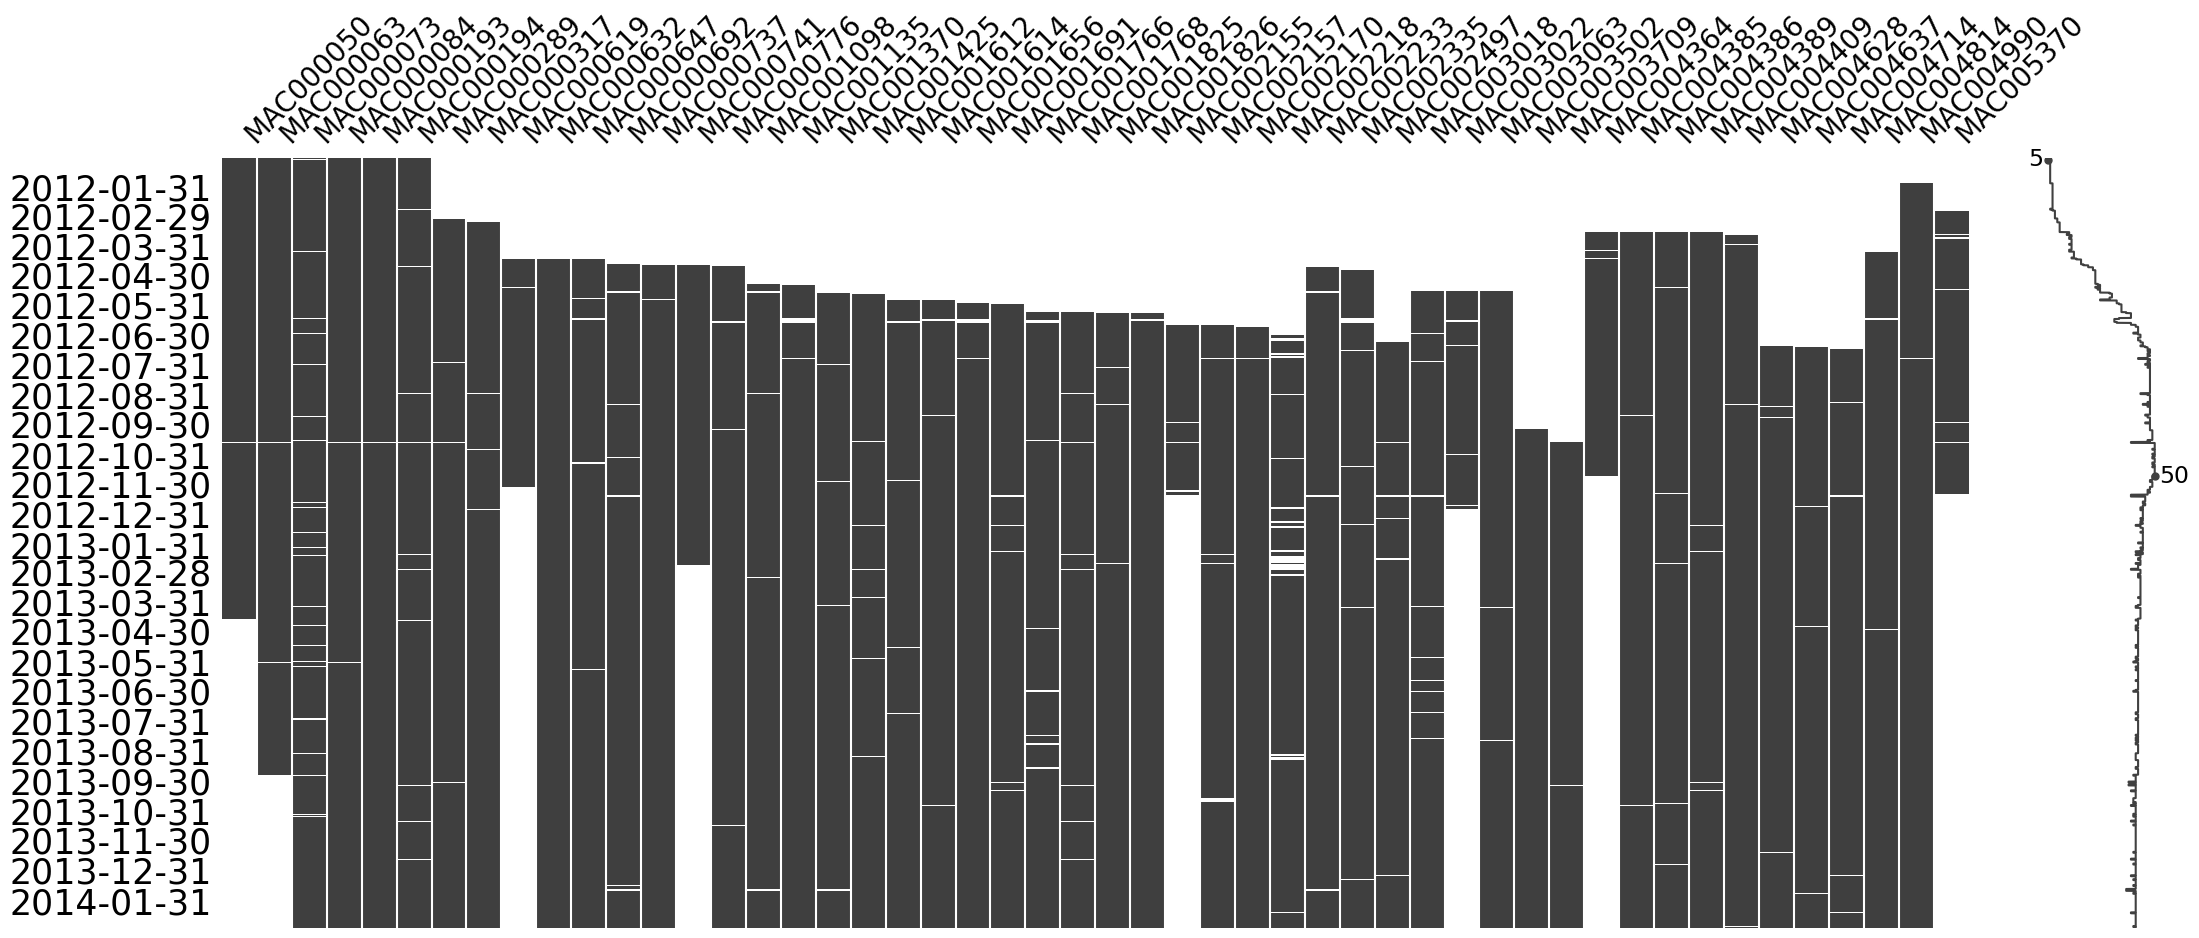

In [9]:
# Pivot the data to set the index as the datetime and the different time series along the columns
plot_df = pd.pivot_table(exp_block_df, index="timestamp", columns="LCLid", values="energy_consumption")
# Generate Plot. Since we have a datetime index, we can mention the frequency to decide what do we want on the X axis
msno.matrix(plot_df, freq="M", fontsize=20)
plt.savefig('imgs/chapter_2/missing_no_full.png', bbox_inches='tight')
plt.show()

In [10]:
# Taking a single time series from the block
ts_df = exp_block_df[exp_block_df.LCLid=="MAC000193"].set_index("timestamp")

We know that there is some missing data between 2012-09-30 and 2012-10-31. But instead of picking a window where there is an actual missing data, let's pick a window where data is present, but we artificially remove it and then look at techniques to fill it. This way, we can have some way to see how well a particular method is working.

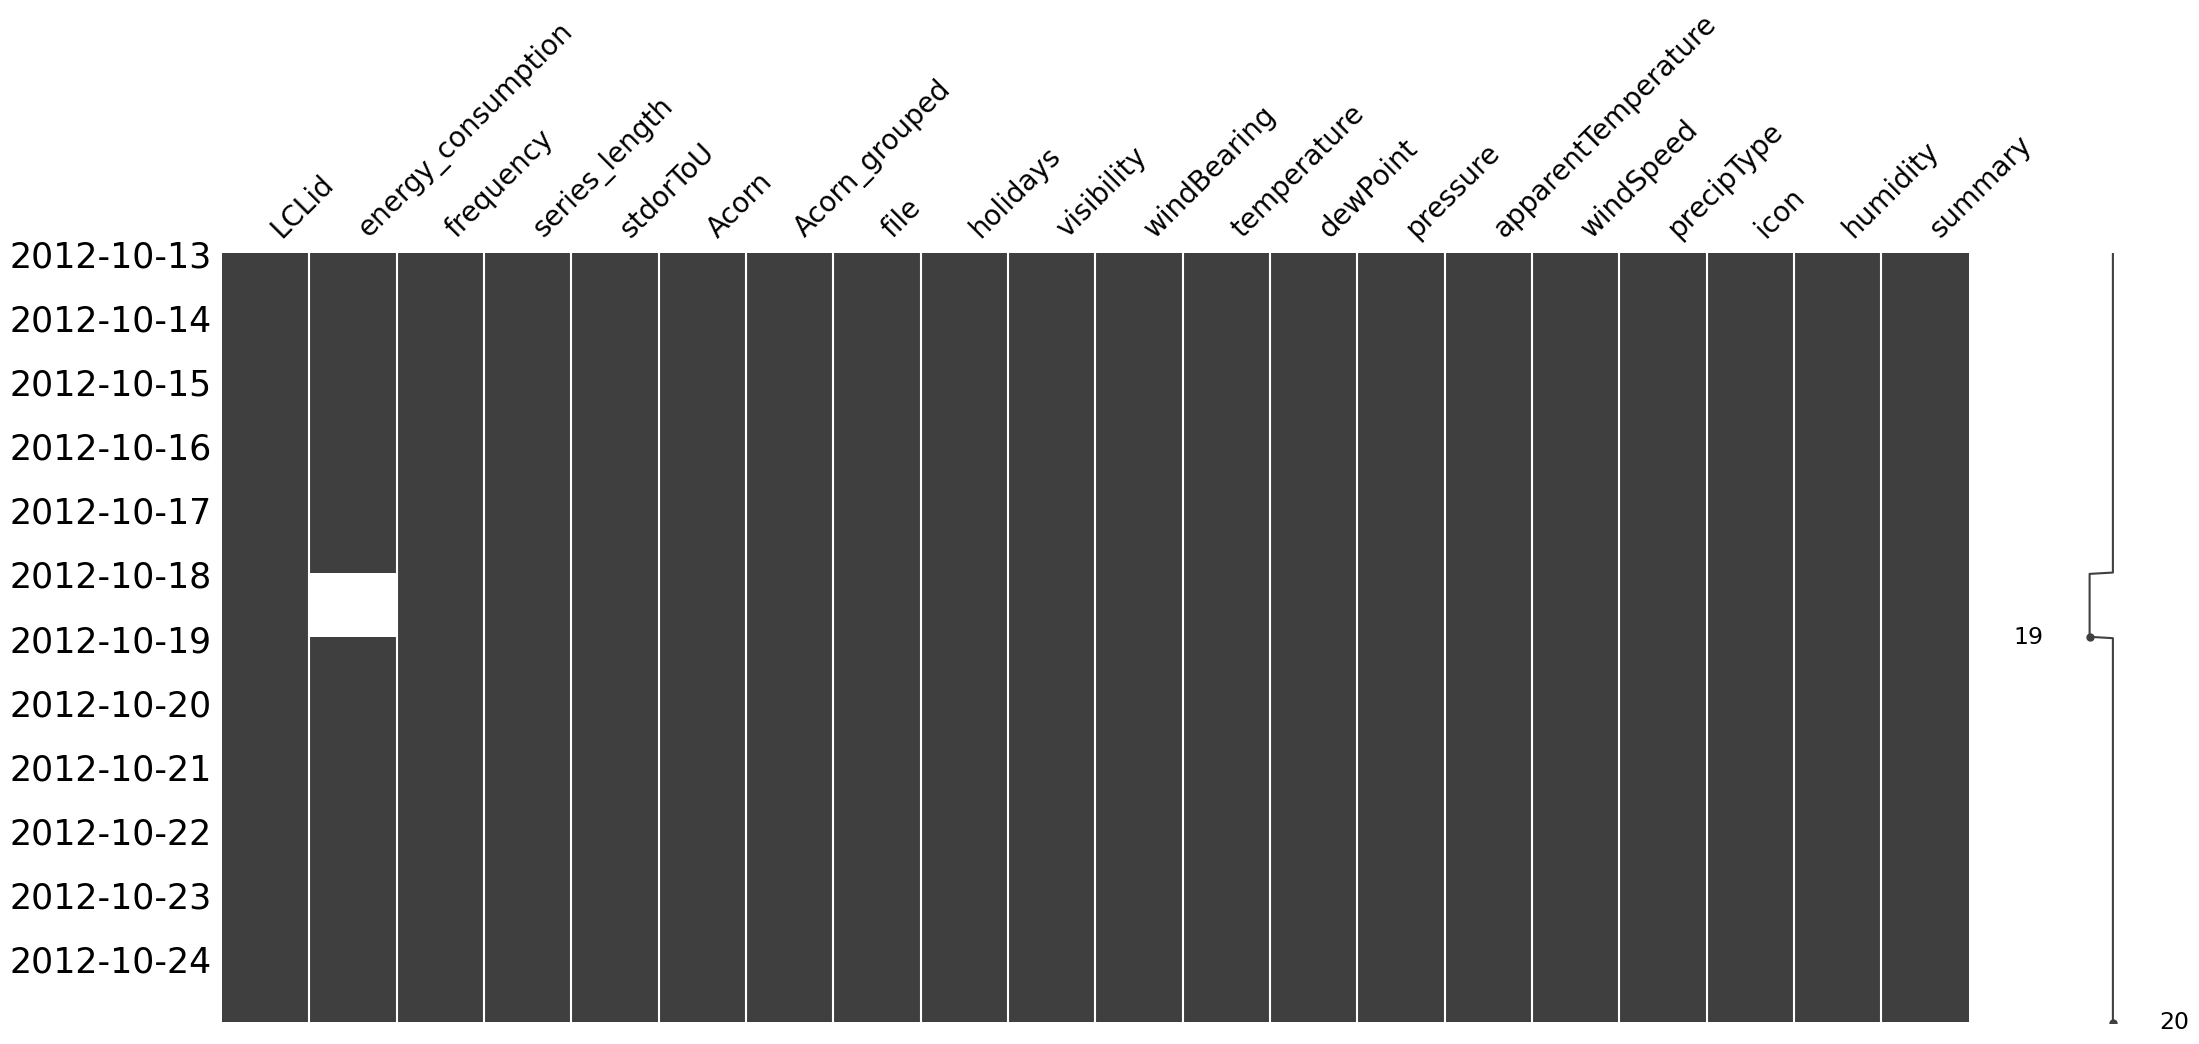

In [11]:
msno.matrix(ts_df["2012-10-13": "2012-10-24"], freq="D", fontsize=20)
plt.savefig('imgs/chapter_2/missing_no_mac000193.png', bbox_inches='tight')
plt.show()

We see that there are two days of information and normally would preceed to fill in the gaps using some of the techniques we will be revieweing. But just to see how effective the different techniques we are reviewing, we will artificially create a missing section and see how well we are able to impute it.

In [12]:
# The dates between which we are nulling out the time series
window = slice("2012-10-07", "2012-10-08")
# Creating a new column and artificially creating missing values
ts_df['energy_consumption_missing'] = ts_df.energy_consumption
ts_df.loc[window, "energy_consumption_missing"] = np.nan
# Creating a new window with a few dats added on either side for visualization purposes
vis_window = slice(pd.to_datetime(window.start) - pd.Timedelta(days=2), pd.to_datetime(window.stop) + pd.Timedelta(days=2))

In [13]:
fig = px.line(ts_df[vis_window], y="energy_consumption_missing", title=f"MAC000193 Energy Consumption between {vis_window.start.strftime('%Y-%m-%d')} and {vis_window.stop.strftime('%Y-%m-%d')}")
fig = format_plot(fig)
fig.write_image("imgs/chapter_2/mac000193_missing.png")
fig.show()

## Missing Data Imputation

In [14]:
null_mask = ts_df.energy_consumption_missing.isnull()

### Repeating Patterns

#### Last Day

In [15]:
#Shifting 48 steps to get previous day
ts_df["prev_day"] = ts_df['energy_consumption'].shift(48)
#Using the shifted column to fill missing
ts_df['prev_day_imputed'] =  ts_df['energy_consumption_missing']
ts_df.loc[null_mask,"prev_day_imputed"] = ts_df.loc[null_mask,"prev_day"]
mae = mean_absolute_error(ts_df.loc[window, "prev_day_imputed"], ts_df.loc[window, "energy_consumption"])

In [16]:
plot_df = pd.melt(ts_df.loc[window,['energy_consumption','prev_day_imputed']].reset_index(), id_vars='timestamp', var_name="series")
fig = px.line(plot_df, x="timestamp", y=["value"], line_dash="series", title=f"Imputing with Previous Day | MAE={mae:.3f}")
fig = format_plot(fig, ['Original', 'Previous Day Imputed'])
fig.write_image("imgs/chapter_2/previous_day_imputation.png")
fig

#### Hourly Profile

In [17]:
#Create a column with the Hour from timestamp
ts_df["hour"] = ts_df.index.hour
#Calculate hourly average consumption
hourly_profile = ts_df.groupby(['hour'])['energy_consumption'].mean().reset_index()
hourly_profile.rename(columns={"energy_consumption": "hourly_profile"}, inplace=True)
#Saving the index because it gets lost in merge
idx = ts_df.index
#Merge the hourly profile dataframe to ts dataframe
ts_df = ts_df.merge(hourly_profile, on=['hour'], how='left', validate="many_to_one")
ts_df.index = idx

#Using the hourly profile to fill missing
ts_df['hourly_profile_imputed'] = ts_df['energy_consumption_missing']
ts_df.loc[null_mask,"hourly_profile_imputed"] = ts_df.loc[null_mask,"hourly_profile"]
mae = mean_absolute_error(ts_df.loc[window, "hourly_profile_imputed"], ts_df.loc[window, "energy_consumption"])

In [18]:
plot_df = pd.melt(ts_df.loc[window,['energy_consumption','hourly_profile_imputed']].reset_index(), id_vars='timestamp', var_name="series")
fig = px.line(plot_df, x="timestamp", y=["value"], line_dash="series", title=f"Imputing with Hourly Profile | MAE={mae:.3f}")
fig = format_plot(fig, ['Original', 'Hourly Profile Imputed'])
fig.write_image("imgs/chapter_2/hourly_profile_imputation.png")
fig

#### Weekday-Hourly Profile

In [19]:
#Create a column with the weekday from timestamp
ts_df["weekday"] = ts_df.index.weekday
#Calculate weekday-hourly average consumption
day_hourly_profile = ts_df.groupby(['weekday','hour'])['energy_consumption'].mean().reset_index()
day_hourly_profile.rename(columns={"energy_consumption": "day_hourly_profile"}, inplace=True)
#Saving the index because it gets lost in merge
idx = ts_df.index
#Merge the day-hourly profile dataframe to ts dataframe
ts_df = ts_df.merge(day_hourly_profile, on=['weekday', 'hour'], how='left', validate="many_to_one")
ts_df.index = idx

#Using the day-hourly profile to fill missing
ts_df['day_hourly_profile_imputed'] = ts_df['energy_consumption_missing']
ts_df.loc[null_mask,"day_hourly_profile_imputed"] = ts_df.loc[null_mask,"day_hourly_profile"]
mae = mean_absolute_error(ts_df.loc[window, "day_hourly_profile_imputed"], ts_df.loc[window, "energy_consumption"])

In [20]:
plot_df = pd.melt(ts_df.loc[window,['energy_consumption','day_hourly_profile_imputed']].reset_index(), id_vars='timestamp', var_name="series")
fig = px.line(plot_df, x="timestamp", y=["value"], line_dash="series", title=f"Imputing with Week Day-Hourly Profile | MAE={mae:.3f}")
fig = format_plot(fig, ['Original', 'Week Day-Hourly Profile Imputed'])
fig.write_image("imgs/chapter_2/day_hourly_profile_imputation.png")
fig

In [21]:
# Hourly Profiles by week Day
px.line(ts_df.loc["2012-10-15": "2012-10-21",['day_hourly_profile','weekday']].reset_index(), x="timestamp", y="day_hourly_profile", color='weekday', title="Hourly Profiles by Weekday (0-Monday - 6-Sunday)")

#### Seasonal Interpolation

In [22]:
from src.imputation.interpolation import SeasonalInterpolation

In [23]:
# Seasonal interpolation using 48*7 as the seasonal period.
# seasonal period is the period after which you expect the pattern to repeat
recovered_matrix_seas_interp_weekday_half_hour = SeasonalInterpolation(seasonal_period=48*7,
                                                     decomposition_strategy="additive", 
                                                     interpolation_strategy="spline", 
                                                     interpolation_args={"order":3}, 
                                                     min_value=0).fit_transform(ts_df.energy_consumption_missing.values.reshape(-1,1))

ts_df['seas_interp_weekday_half_hour_imputed'] = recovered_matrix_seas_interp_weekday_half_hour
mae_weekday_half_hour = mean_absolute_error(ts_df.loc[window, "seas_interp_weekday_half_hour_imputed"], ts_df.loc[window, "energy_consumption"])

In [24]:
recovered_matrix_seas_interp_half_hour = SeasonalInterpolation(seasonal_period=48,
                                                     decomposition_strategy="additive", 
                                                     interpolation_strategy="spline", 
                                                     interpolation_args={"order":3}, 
                                                     min_value=0).fit_transform(ts_df.energy_consumption_missing.values.reshape(-1,1))

ts_df['seas_interp_half_hour_imputed'] = recovered_matrix_seas_interp_half_hour
mae_half_hour = mean_absolute_error(ts_df.loc[window, "seas_interp_half_hour_imputed"], ts_df.loc[window, "energy_consumption"])

In [25]:
plot_df = pd.melt(ts_df.loc[window,['energy_consumption', "seas_interp_half_hour_imputed", 'seas_interp_weekday_half_hour_imputed']].reset_index(), id_vars='timestamp', var_name="series")
fig = px.line(plot_df, x="timestamp", y=["value"], line_dash="series", title=f"Imputing with Seasonal Interpolation <br> MAE Half Hourly={mae_half_hour:.3f} | MAE Weekday-Half Hourly={mae_weekday_half_hour:.3f}")
fig = format_plot(fig, ['Original', 'Half Hourly Profile Imputed', 'Week Day-Half Hourly Profile Imputed'], title_font_size=16)
fig.write_image("imgs/chapter_2/seasonal_interpolation_imputation.png")
fig

### Summary

In [26]:
imputed_columns = [col for col in ts_df.columns if "imputed" in col]
original_col = "energy_consumption"

In [27]:
act = ts_df.loc[window, original_col].values
mae_d = {}
for col in imputed_columns:
    mae_d[col] = mean_absolute_error(act, ts_df.loc[window, col].values)

In [28]:
mae_d.keys()

dict_keys(['prev_day_imputed', 'hourly_profile_imputed', 'day_hourly_profile_imputed', 'seas_interp_weekday_half_hour_imputed', 'seas_interp_half_hour_imputed'])

In [29]:
res_df = pd.DataFrame.from_dict(mae_d, orient="index").reset_index()
res_df.columns=["Imputation", "MAE"]
res_df.Imputation = res_df.Imputation.map({
 'prev_day_imputed': "Previous Day",
 'hourly_profile_imputed': "Hourly Profile",
 'day_hourly_profile_imputed': "Day-Hourly Profile",
 'seas_interp_weekday_half_hour_imputed': "Seasonal Interpolation Weekday-Half Hourly",
 'seas_interp_half_hour_imputed': "Seasonal Interpolation Half Hourly"
})

In [30]:
res_df

,Imputation,MAE
0,Previous Day,0.167896
1,Hourly Profile,0.121326
2,Day-Hourly Profile,0.116652
3,Seasonal Interpolation Weekday-Half Hourly,0.120024
4,Seasonal Interpolation Half Hourly,0.121568


In [31]:
px.line(ts_df.loc[window, imputed_columns+[original_col]].reset_index(), x="timestamp", y=imputed_columns+[original_col])